## 进程API
### fork()系统调用
---
unix系统采用fork()和exec()系统调用进行新进程的创建，同时进程还可以通过wait()来等待其子进程的执行完成。

```c
...
# getpid()获取当前pid，fork()创建子进程
int rc = fork(); # 返回一个整形（PID），-1代表失败

```

fork()出来的子进程，拥有自己的地址空间，创建子进程，父进程得到的是子进程的PID(rc的值)，而子进程也会被分配rc的值（为0），就算考虑在单核CPU，子进程和父进程的输出先后也是带有不确定性的。

CPU调度程序决定了某个时刻哪个进程被执行，而在后面涉及到对并发（concurrency）问题的讨论时，我们会见到许多不确定性。

### wait()系统调用

有时候我们希望子进程先执行完，退出后，父进程再执行接下来的，具体来说，代码：

```c
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <sys/wait.h>

int
main(int argc, char *argv[])
{
    printf("hello world (pid:%d)\n", (int) getpid());
    int rc = fork();
    if (rc < 0) {
        // fork failed; exit
        fprintf(stderr, "fork failed\n");
        exit(1);
    } else if (rc == 0) {
        // child (new process)
        printf("hello, I am child (pid:%d)\n", (int) getpid());
	sleep(1);
    } else {
        // parent goes down this path (original process)
        int wc = wait(NULL);
        printf("hello, I am parent of %d (wc:%d) (pid:%d)\n",
	       rc, wc, (int) getpid());
    }
    return 0;
}

```

输出结果：

```shell
prompt> ./p2
hello world (pid:29266)
hello, I am child (pid:29267)
hello, I am parent of 29267 (wc:29267) (pid:29266)
prompt>
```

### exec()系统调用
exec()系统调用可以让子进程执行与父进程不同的程序。看代码

```C
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <string.h>
#include <sys/wait.h>

int
main(int argc, char *argv[])
{
    printf("hello world (pid:%d)\n", (int) getpid());
    int rc = fork();
    if (rc < 0) {
        // fork failed; exit
        fprintf(stderr, "fork failed\n");
        exit(1);
    } else if (rc == 0) {
        // child (new process)
        printf("hello, I am child (pid:%d)\n", (int) getpid());
        char *myargs[3];
        myargs[0] = strdup("wc");   // program: "wc" (word count)
        myargs[1] = strdup("p3.c"); // argument: file to count
        myargs[2] = NULL;           // marks end of array
        execvp(myargs[0], myargs);  // runs word count
        printf("this shouldn't print out");
    } else {
        // parent goes down this path (original process)
        int wc = wait(NULL);
        printf("hello, I am parent of %d (wc:%d) (pid:%d)\n",
	       rc, wc, (int) getpid());
    }
    return 0;
}
```
此例中，子进程调用execvp()来运行字符来运行计数程序wc。针对源代码P3.c运行wc，从而告诉我们该文件有多少行，多少单词，以及多少字节，我们看一下输出。

```shell
prompt> ./p3
hello world (pid:29383)
hello, I am child (pid:29384)
29 107 1030 p3.c
hello, I am parent of 29384 (wc:29384) (pid:29383)
```

exec()从可执行程序中加载代码以及静态数据，并覆写自己的代码段，堆栈以及内存空间也会被重新初始化，接着通过argv传递参数给进程，因此他是直接覆盖掉了当前的程序，p3.c后半部分的代码则并不会执行。

### 为何这样设计API
fork(),exec()在构建UNIX shell的时候非常有用，其原因是提供一套机制：使得shell在fork之后exec之前运行代码的机会。

让我们看看使用shell的工作场景下，是如何使用上述的系统调用的，想象一个repl（你的shell），你键入了你的命令，shell在文件系统中找到这个可执行程序，然后调用fork()创建新的进程，然后调用exec()的某个变体来执行该程序，主进程（shell）则等待其完成（利用wait()）。那么这种设计能实现哪些有趣的操作呢？请看:

```shell
wc p3.c > newfile.txt
```
wc的输出结果被重定向到newfile.txt中，实际的过程是fork()了一个进程，并预先关闭标准输出，打开文件。这样运行的程序输出结果就被发送到了该文件，而不是打印在屏幕上。

重定向的原理：UNIX从0开始寻找可以使用的文件描述符，请看代码：

```c
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <string.h>
#include <fcntl.h>
#include <assert.h>
#include <sys/wait.h>

int
main(int argc, char *argv[])
{
    int rc = fork();
    if (rc < 0) {
        // fork failed; exit
        fprintf(stderr, "fork failed\n");
        exit(1);
    } else if (rc == 0) {
	// child: redirect standard output to a file
	close(STDOUT_FILENO); 
	open("./p4.output", O_CREAT|O_WRONLY|O_TRUNC, S_IRWXU);

	// now exec "wc"...
        char *myargs[3];
        myargs[0] = strdup("wc");   // program: "wc" (word count)
        myargs[1] = strdup("p4.c"); // argument: file to count
        myargs[2] = NULL;           // marks end of array
        execvp(myargs[0], myargs);  // runs word count
    } else {
        // parent goes down this path (original process)
        int wc = wait(NULL);
	assert(wc >= 0);
    }
    return 0;
}
```
重定向以及执行结果

```c
prompt> ./p4
prompt> cat p4.output
32 109 846 p4.c
```

可能你由此联想到了UNIX的管道，pipe()系统调用，一个进程的输出被连接到了一个内核管道（队列）上，同时另一个进程的输入也被连接到了同一个管道上，因此前一个进程的输出无缝地作为后一个进程的输入，就比如我们常用的 | grep 作为管道搜索。


## 机制：受限直接执行（Limited Direct Execution）
---
通过time sharing CPU，实现了虚拟化。
加入自己是设计者，我们应该考虑几个问题：
* 不增加开销的情况下实现虚拟化
* 控制权

### 基本技巧
首先，受限的“直接执行”是OS的运行机制，直接运行的协议如图：
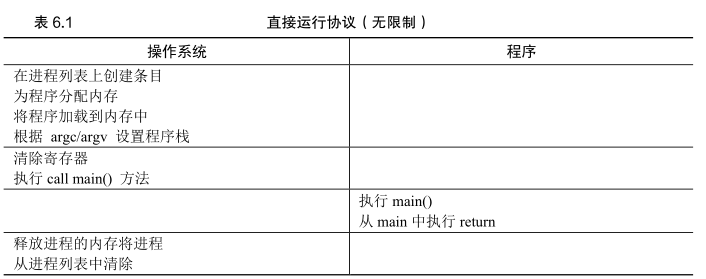

硬件通过不同的执行模式来协助操作系统。

采用受保护的控制权转移：这一块《现代操作系统》说的已经够多了，无需多加说明。

内核模式（kernel mode）——操作系统以内核模式运行，它可以做它喜欢的事，包括I/O指令以及执行所有类型的受限指令。

一个用户模式的程序执行过程中，要执行系统调用，则程序必须执行特殊的TRAP指令，指令会跳入内核并将其特权提升到内核模式。

* 内核必须谨慎地控制在陷阱上执行的代码（发起调用并不能指定要跳转的地址）
* 由上面一点，内核启动是由设置陷阱表来实现的。（trap table）。

上面所说的一点，实际执行过程是： 机器启动时，它在内核模式下执行，因此可以根据需要自行配置机器硬件。操作系统所做的事：
1. 告诉硬件在发生某一些异常时应该执行哪一些代码。
2. OS会通过某些特殊的指令，通知硬件陷阱处理程序的位置（使得发生系统调用时，应该跳转到哪一段代码）
3. 能够知道，这个所谓的“告知”，也是一项特权操作。

总结一个启动后的时间线：

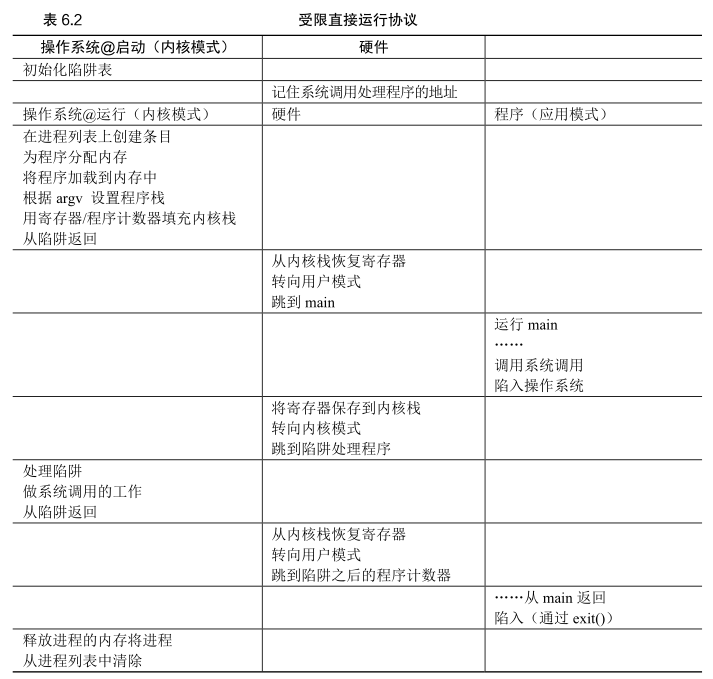

暂将上面的过程称之为LDE。

系统引导时，内核初始化陷阱表，CPU记住陷阱表的位置供随后使用。在进程的执行过程中，分配内存的操作是由内核进行的。

## 问题：进程之间的切换

一个很有趣的问题：加入一个进程正占用着CPU，那么如果操作系统应该是没有运行的，OS怎么能做接下来的操作？

**键的问题来了:操作系统如何重获CPU的控制权？，以便CPU的占用能在不同的进程之间切换**

